# Model tuning
In the previous notebooks, I have assembled 290 features to predict if a client defaults on a given loan. <br>
I will now try different models and methods to increase accuracy and hopefully achieve a ROC AUC of 0.8 on the test set.

## TODO / Ideas
- add batch noise to NN
- Feed categorical embeddings from NN into LightGBM
- Cross validation
- Hyperparameter tuning
- Ensembling

In [18]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Set up datasets

In [37]:
df = pd.read_csv('dataset_reduced.csv', low_memory=False)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
train = df[df.test == 0].drop(columns=['test', 'SK_ID_CURR'])
test = df[df.test == 1].drop(columns=['test', 'SK_ID_CURR']) ## save away test set for later submission to kaggle

I want to compare LightGBM and Neural nets. To make sure both use the same train/test split, I manually assign the splits beforehand. This also allows me to do ensembling or to take outputs from the neural net and feed them into LightGBM without leaking information.

In [43]:
def valid_split(df, ratio, return_split=False):
    ix = np.random.choice(df.index, size=int(len(df)*ratio), replace=False)
    df['valid'] = False
    df.loc[ix, 'valid'] = True

    return df

In [44]:
def split_datasets(df):
    X_train = df[df.valid == False].drop(columns=['valid', 'TARGET'])
    X_test = df[df.valid == True].drop(columns=['valid', 'TARGET'])
    y_train = df.loc[df.valid == False, 'TARGET']
    y_test = df.loc[df.valid == True, 'TARGET']
    
    return X_train, X_test, y_train, y_test

In [45]:
train = valid_split(train, 0.2)

In [ ]:
## make sure all category columns are classified as such
cat = list(train.select_dtypes(include=['category', 'object']).columns)
for c in cat:
    train[c] = train[c].astype('category')

In [46]:
train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_INSTALMENT_max_max,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,valid
0,1.0,Cash loans,M,406597.5,24700.5,Secondary / secondary special,Single / not married,0.018801,-9461,-637.0,...,219625.700,53093.746,219625.700,175783.73,175783.73,219625.700,219625.690,1008781.200,4.172888e+06,True
1,0.0,Cash loans,F,1293502.5,35698.5,Higher education,Married,0.003541,-16765,-1188.0,...,80773.380,560835.400,453952.220,1154108.20,1154108.20,1150977.400,1618864.600,4394101.500,1.134881e+07,False
2,0.0,Revolving loans,M,135000.0,6750.0,Secondary / secondary special,Single / not married,0.010032,-19046,-225.0,...,21288.465,10573.965,21288.465,16071.75,16071.75,21288.465,21288.465,31721.895,6.386539e+04,False
3,0.0,Cash loans,F,312682.5,29686.5,Secondary / secondary special,Civil marriage,0.008019,-19005,-3039.0,...,25091.324,691786.900,232499.700,994476.70,994476.70,691786.900,1007153.400,1057860.200,3.719995e+06,False
4,0.0,Cash loans,M,513000.0,21865.5,Secondary / secondary special,Single / not married,0.028663,-19932,-3038.0,...,18330.390,22678.785,172669.890,483756.38,825845.80,280199.700,806127.940,836703.400,1.139621e+07,False


## Get baseline - LightGBM
LightGBM achieves a ROC AUC of 0.7881, which is very good already. <br>
There are 13663 false negatives and 1671 false positives.

In [49]:
X_train, X_test, y_train, y_test = split_datasets(train)

In [52]:
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [53]:
model.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'auc',
          callbacks = [lgb.early_stopping(100), lgb.log_evaluation(100)])

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.786554	valid_0's binary_logloss: 0.532645
[200]	valid_0's auc: 0.787884	valid_0's binary_logloss: 0.50453
Early stopping, best iteration is:
[196]	valid_0's auc: 0.788121	valid_0's binary_logloss: 0.505152


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

In [54]:
def print_confusion(model):
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual No Default', 'Actual Default'], 
                                 index=['Predict No Default', 'Predict Default'])
    
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

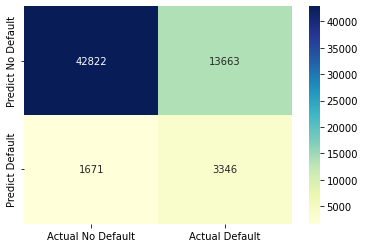

In [55]:
print_confusion(model)

### Oversampling
Only around 8% of all loans in the dataset default. Class imbalance could potentially be a problem. <br>
I randomly oversample default loans up to 50% of the non-default loans. In other words, the resulting dataset contains 1/3 default loans.

In [56]:
def oversample(X, y, ratio=0.5, noise=False):
    df = X.copy()
    df['TARGET'] = y

    n_maj = len(df[df.TARGET == 0])
    n_min = len(df[df.TARGET == 1])
    current_ratio = n_min / n_maj
    
    n_new = int(ratio / current_ratio * n_min - n_min)
    print('Build {} new features.'.format(n_new))
    
    new_sample = df[df.TARGET == 1].sample(n_new, replace=True, ignore_index=True)
    
    df = df.append(new_sample)
    
    return df.drop(columns=['TARGET']), df['TARGET']

In [57]:
X_train_os, y_train_os = oversample(X_train, y_train)

Build 93292 new features.


In [59]:
len(X_train_os),len(y_train_os)

(339301, 339301)

The model performs slightly worse. Random Forests are pretty robust to class imbalance, so oversampling is probably not necessary. <br>
Maybe more advanced oversampling methods like SMOTE or Autoencoders could net better results.

In [60]:
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [61]:
model.fit(X_train_os, y_train_os, eval_set = [(X_test, y_test)], eval_metric = 'auc',
          callbacks = [lgb.early_stopping(100), lgb.log_evaluation(100)])

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.784474	valid_0's binary_logloss: 0.526652
[200]	valid_0's auc: 0.783272	valid_0's binary_logloss: 0.498204
Early stopping, best iteration is:
[125]	valid_0's auc: 0.785468	valid_0's binary_logloss: 0.518171


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

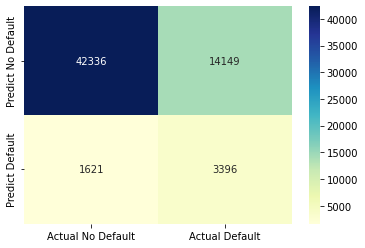

In [62]:
print_confusion(model)

## Neural net
I try out a neural net for comparison. <br>
While the ROC AUC isnt that much worse at 0.7746, the confusion matrix shows that the algorithm is almost incapable of predicting defaults. Only 198 defaults are correctly classified.

In [104]:
valid_idx = list(train[train.valid == True].index)
cont_names, cat_names = cont_cat_split(train, dep_var='TARGET')

procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(train, valid_idx=valid_idx, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names='TARGET', y_block=CategoryBlock, bs=512)
dls.show_batch()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,FLAG_WORK_PHONE,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_16,valid,AMT_ANNUITY_na,DAYS_EMPLOYED_na,OWN_CAR_AGE_na,EXT_SOURCE_1_na,EXT_SOURCE_2_na,EXT_SOURCE_3_na,APARTMENTS_AVG_na,BASEMENTAREA_AVG_na,YEARS_BEGINEXPLUATATION_AVG_na,YEARS_BUILD_AVG_na,COMMONAREA_AVG_na,ENTRANCES_AVG_na,FLOORSMAX_AVG_na,FLOORSMIN_AVG_na,LANDAREA_AVG_na,LIVINGAREA_AVG_na,NONLIVINGAPARTMENTS_AVG_na,NONLIVINGAREA_AVG_na,OBS_30_CNT_SOCIAL_CIRCLE_na,DEF_30_CNT_SOCIAL_CIRCLE_na,DEF_60_CNT_SOCIAL_CIRCLE_na,DAYS_LAST_PHONE_CHANGE_na,AMT_REQ_CREDIT_BUREAU_QRT_na,annuity_pct_na,credit_term_na,ext_mean_na,bureau_CREDIT_TYPE_Mortgage_mean_x_na,bureau_CREDIT_TYPE_Microloan_mean_x_na,bureau_CREDIT_TYPE_Carloan_mean_x_na,bureau_CREDIT_TYPE_Creditcard_sum_x_na,bureau_CREDIT_ACTIVE_Active_mean_x_na,bureau_CREDIT_TYPE_Consumercredit_mean_x_na,bureau_CREDIT_ACTIVE_Active_sum_x_na,bureau_CREDIT_ACTIVE_Closed_sum_x_na,bureau_DAYS_CREDIT_sum_x_na,bureau_DAYS_CREDIT_min_x_na,bureau_DAYS_CREDIT_ENDDATE_min_x_na,bureau_DAYS_ENDDATE_FACT_min_x_na,bureau_DAYS_ENDDATE_FACT_mean_x_na,bureau_DAYS_CREDIT_mean_x_na,bureau_DAYS_ENDDATE_FACT_max_x_na,bureau_DAYS_CREDIT_UPDATE_min_x_na,bureau_DAYS_CREDIT_UPDATE_mean_x_na,bureau_DAYS_CREDIT_max_x_na,bureau_DAYS_CREDIT_UPDATE_max_x_na,bureau_AMT_CREDIT_SUM_OVERDUE_mean_x_na,bureau_AMT_CREDIT_SUM_OVERDUE_max_x_na,bureau_AMT_CREDIT_SUM_DEBT_min_x_na,bureau_AMT_CREDIT_MAX_OVERDUE_count_x_na,bureau_AMT_CREDIT_SUM_LIMIT_mean_x_na,bureau_AMT_CREDIT_MAX_OVERDUE_sum_x_na,bureau_AMT_CREDIT_SUM_LIMIT_sum_x_na,bureau_credit_term_mean_x_na,bureau_AMT_CREDIT_SUM_LIMIT_count_x_na,bureau_credit_term_count_x_na,bureau_DAYS_CREDIT_ENDDATE_mean_x_na,bureau_DAYS_CREDIT_ENDDATE_sum_x_na,bureau_DAYS_CREDIT_ENDDATE_max_x_na,bureau_AMT_ANNUITY_max_x_na,bureau_AMT_CREDIT_SUM_DEBT_mean_x_na,bureau_AMT_CREDIT_SUM_min_x_na,bureau_AMT_CREDIT_SUM_mean_x_na,bureau_AMT_CREDIT_SUM_DEBT_max_x_na,client_bureau_balance_MONTHS_BALANCE_sum_min_na,client_bureau_balance_MONTHS_BALANCE_max_sum_na,client_bureau_balance_MONTHS_BALANCE_max_mean_na,client_bureau_balance_STATUS_1_mean_mean_na,client_bureau_balance_STATUS_0_mean_min_na,client_bureau_balance_STATUS_X_mean_mean_na,client_bureau_balance_STATUS_0_mean_mean_na,client_bureau_balance_STATUS_C_mean_mean_na,client_bureau_balance_STATUS_X_mean_max_na,client_bureau_balance_STATUS_C_mean_max_na,client_bureau_balance_STATUS_0_mean_max_na,client_bureau_balance_STATUS_1_sum_max_na,client_bureau_balance_STATUS_X_mean_sum_na,client_bureau_balance_STATUS_0_mean_sum_na,client_bureau_balance_STATUS_C_mean_sum_na,client_bureau_balance_STATUS_X_sum_mean_na,client_bureau_balance_STATUS_0_sum_mean_na,client_bureau_balance_STATUS_0_sum_max_na,client_bureau_balance_STATUS_0_sum_sum_na,previous_DAYS_DECISION_sum_na,previous_DAYS_DECISION_min_na,previous_DAYS_DECISION_mean_na,previous_DAYS_DECISION_max_na,previous_DAYS_FIRST_DUE_min_na,previous_DAYS_FIRST_DUE_mean_na,previous_DAYS_LAST_DUE_sum_na,previous_DAYS_LAST_DUE_min_na,previous_DAYS_LAST_DUE_mean_na,previous_DAYS_LAST_DUE_max_na,previous_DAYS_LAST_DUE_1ST_VERSION_sum_na,previous_DAYS_LAST_DUE_1ST_VERSION_min_na,previous_DAYS_LAST_DUE_1ST_VERSION_mean_na,previous_credit_delta_min_na,previous_credit_delta_mean_na,previous_credit_delta_max_na,previous_credit_delta_sum_na,previous_NFLAG_INSURED_ON_APPROVAL_mean_na,previous_NFLAG_INSURED_ON_APPROVAL_sum_na,previous_RATE_DOWN_PAYMENT_min_na,previous_RATE_DOWN_PAYMENT_mean_na,previous_RATE_DOWN_PAYMENT_max_na,previous_RATE_DOWN_PAYMENT_sum_na,previous_credit_term_min_na,previous_credit_term_mean_na,previous_credit_term_max_na,previous_credit_term_sum_na,previous_CNT_PAYMENT_mean_na,previous_CNT_PAYMENT_max_na,previous_CNT_PAYMENT_sum_na,previous_HOUR_APPR_PROCESS_START_min_na,previous_HOUR_APPR_PROCESS_START_mean_na,previous_HOUR_APPR_PROCESS_START_max_na,pre

In [105]:
learn = tabular_learner(dls, metrics=[RocAucBinary()], cbs=[EarlyStoppingCallback(patience=3)])

SuggestedLRs(valley=0.0014454397605732083)

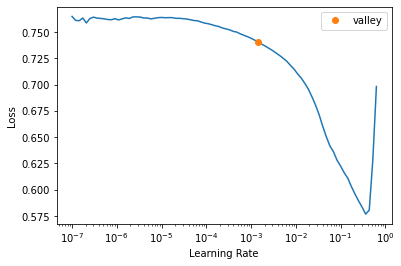

In [72]:
learn.lr_find()

In [106]:
learn.fit(10, 0.001)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.248946,0.253402,0.755045,00:17
1,0.241611,0.243923,0.775652,00:17
2,0.244456,0.244358,0.773911,00:17
3,0.240616,0.245362,0.775212,00:17
4,0.231937,0.243717,0.774574,00:18
5,0.230979,0.246538,0.772068,00:17
6,0.231847,0.249131,0.763567,00:17
7,0.222145,0.255245,0.762380,00:17


No improvement since epoch 4: early stopping


In [107]:
def print_confusion_nn(learner):
    pred, targ = learn.get_preds(dl=dls.valid)
    pred = np.arange(pred.shape[1])[np.argmax(pred, axis=1)]
    
    cm = confusion_matrix(targ, pred)
    
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual No Default', 'Actual Default'], 
                            index=['Predict No Default', 'Predict Default'])
    
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

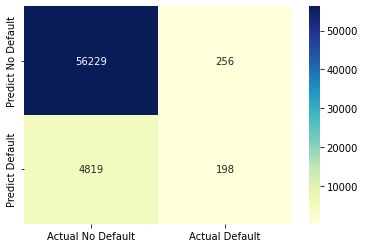

In [108]:
print_confusion_nn(learn)

### Oversampling
Oversampling significantly improves the amount of correctly classified defaults from 196 to 262. However this is still very bad compared to LightGBM. <br>

In [109]:
dls.train.xs, dls.train.y = oversample(dls.train.xs, dls.train.y)

Build 93292 new features.


In [110]:
learn = tabular_learner(dls, metrics=[RocAucBinary()], cbs=[EarlyStoppingCallback(patience=3)])

In [111]:
learn.fit(10, 0.001)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.248248,0.251617,0.773093,00:18
1,0.243318,0.261704,0.771478,00:17
2,0.239504,0.244690,0.773534,00:17
3,0.235557,0.246698,0.775682,00:17
4,0.231661,0.244798,0.773711,00:17
5,0.231652,0.251119,0.767902,00:17


No improvement since epoch 2: early stopping


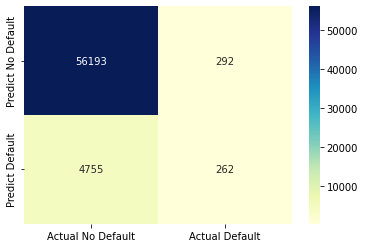

In [112]:
print_confusion_nn(learn)